In [5]:
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [6]:

# Model
class DeepMLPClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dims=[768, 512, 256], output_dim=16):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.LayerNorm(dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)  # Raw logits

In [7]:
# Load Data
df = pd.read_csv('proper_df (7).csv')
df['model_family_vector'] = df['model_family_vector'].apply(ast.literal_eval)
y = np.stack(df['model_family_vector'].values).astype(np.float32)
X = np.load('bert_embeddings (1).npy')

In [8]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor Conversion
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

In [9]:
# Initialize Model
model = DeepMLPClassifier(output_dim=y.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 5.4762
Epoch 2, Loss: 3.9598
Epoch 3, Loss: 3.5665
Epoch 4, Loss: 2.9781
Epoch 5, Loss: 2.4319
Epoch 6, Loss: 1.8962
Epoch 7, Loss: 1.4560
Epoch 8, Loss: 1.1438
Epoch 9, Loss: 0.9106
Epoch 10, Loss: 0.7329
Epoch 11, Loss: 0.5519
Epoch 12, Loss: 0.4035
Epoch 13, Loss: 0.3681
Epoch 14, Loss: 0.3423
Epoch 15, Loss: 0.2936
Epoch 16, Loss: 0.2720
Epoch 17, Loss: 0.2475
Epoch 18, Loss: 0.1773
Epoch 19, Loss: 0.2600
Epoch 20, Loss: 0.2012
Epoch 21, Loss: 0.1333
Epoch 22, Loss: 0.1130
Epoch 23, Loss: 0.0906
Epoch 24, Loss: 0.0836
Epoch 25, Loss: 0.0846
Epoch 26, Loss: 0.0699
Epoch 27, Loss: 0.0620
Epoch 28, Loss: 0.0780
Epoch 29, Loss: 0.0529
Epoch 30, Loss: 0.0514
Epoch 31, Loss: 0.0458
Epoch 32, Loss: 0.0336
Epoch 33, Loss: 0.0261
Epoch 34, Loss: 0.0287
Epoch 35, Loss: 0.0249
Epoch 36, Loss: 0.0246
Epoch 37, Loss: 0.0227
Epoch 38, Loss: 0.0199
Epoch 39, Loss: 0.0283
Epoch 40, Loss: 0.0473
Epoch 41, Loss: 0.0434
Epoch 42, Loss: 0.0610
Epoch 43, Loss: 0.0356
Epoch 44, Loss: 0.02

In [10]:
# Evaluate
model.eval()
with torch.no_grad():
    y_pred_prob = torch.sigmoid(model(X_test_tensor)).numpy()
    y_pred_bin = (y_pred_prob >= 0.2).astype(int)

# Metrics
def exact_match(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

print(" Evaluation:")
print("Exact Match Accuracy:", exact_match(y_test, y_pred_bin))
print("Micro F1 Score:", f1_score(y_test, y_pred_bin, average='micro', zero_division=1))
print("Macro F1 Score:", f1_score(y_test, y_pred_bin, average='macro', zero_division=1))
print("Hamming Loss:", hamming_loss(y_test, y_pred_bin))

 Evaluation:
Exact Match Accuracy: 0.5797101449275363
Micro F1 Score: 0.6754098360655738
Macro F1 Score: 0.7639300500194418
Hamming Loss: 0.04483695652173913


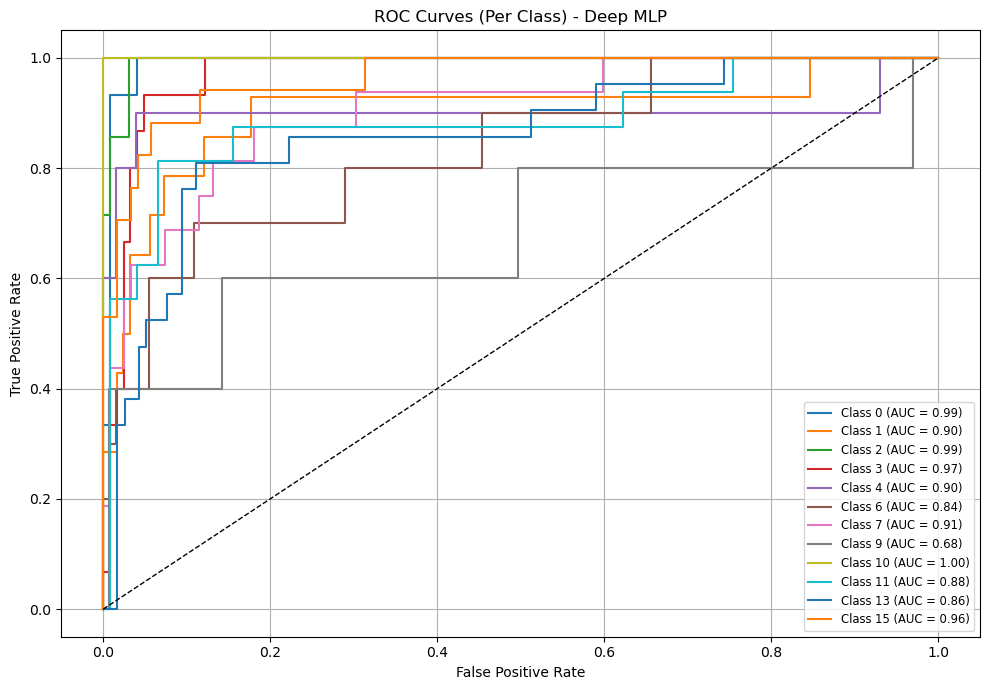

In [11]:
y_test = y_test_tensor.numpy()
y_pred_prob = np.array(y_pred_prob)

n_classes = y_test.shape[1]

# === Plot 1: Per-Class ROC Curves ===
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    if np.sum(y_test[:, i]) == 0:  # Skip dead labels
        continue
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curves (Per Class) - Deep MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

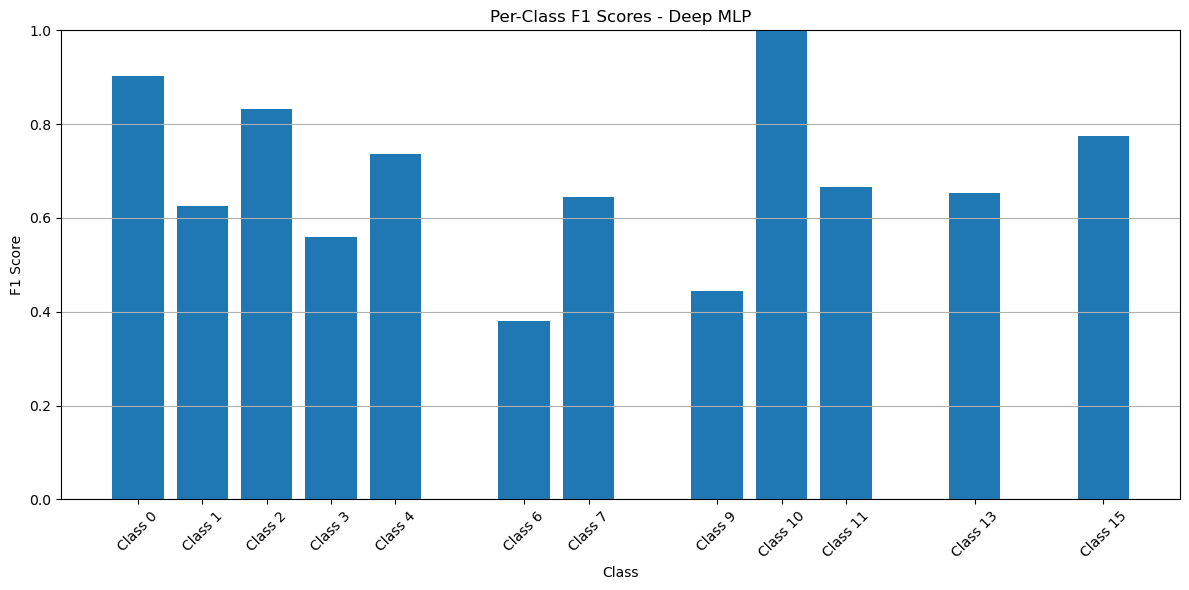

In [12]:
# === Plot 2: Per-Class F1 Scores ===
f1_scores = []
class_indices = []
for i in range(n_classes):
    if np.sum(y_test[:, i]) == 0:
        continue
    f1 = f1_score(y_test[:, i], y_pred_bin[:, i], zero_division=0)
    f1_scores.append(f1)
    class_indices.append(i)

plt.figure(figsize=(12, 6))
plt.bar(class_indices, f1_scores, tick_label=[f"Class {i}" for i in class_indices])
plt.ylabel("F1 Score")
plt.xlabel("Class")
plt.title("Per-Class F1 Scores - Deep MLP")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

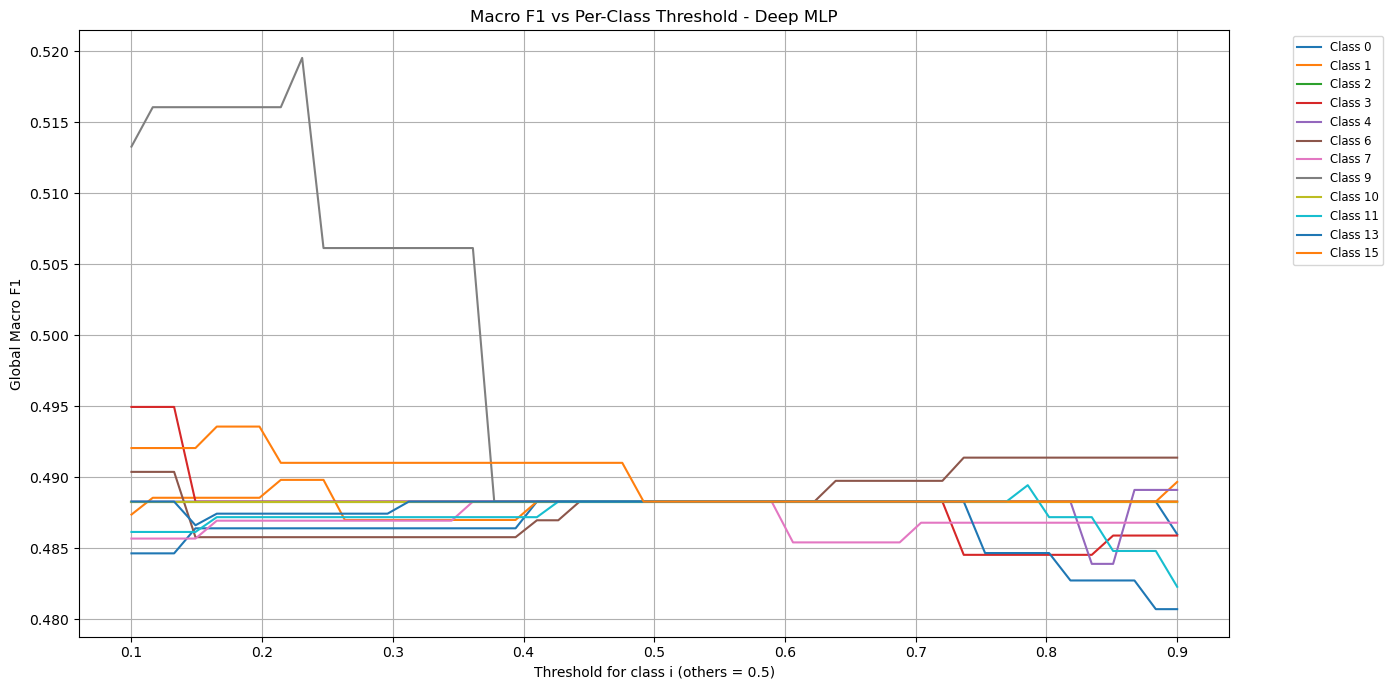

In [13]:
# === Plot 3: Macro F1 vs Per-Class Threshold ===
thresholds = np.linspace(0.1, 0.9, 50)
num_classes = y_test.shape[1]

plt.figure(figsize=(14, 7))
for i in range(num_classes):
    if np.sum(y_test[:, i]) == 0:
        continue  # skip dead class
    macro_f1s = []
    for t in thresholds:
        test_thresholds = np.full(num_classes, 0.5)
        test_thresholds[i] = t
        y_pred_temp = (y_pred_prob >= test_thresholds).astype(int)
        score = f1_score(y_test, y_pred_temp, average='macro', zero_division=0)
        macro_f1s.append(score)
    plt.plot(thresholds, macro_f1s, label=f'Class {i}')

plt.xlabel("Threshold for class i (others = 0.5)")
plt.ylabel("Global Macro F1")
plt.title("Macro F1 vs Per-Class Threshold - Deep MLP")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

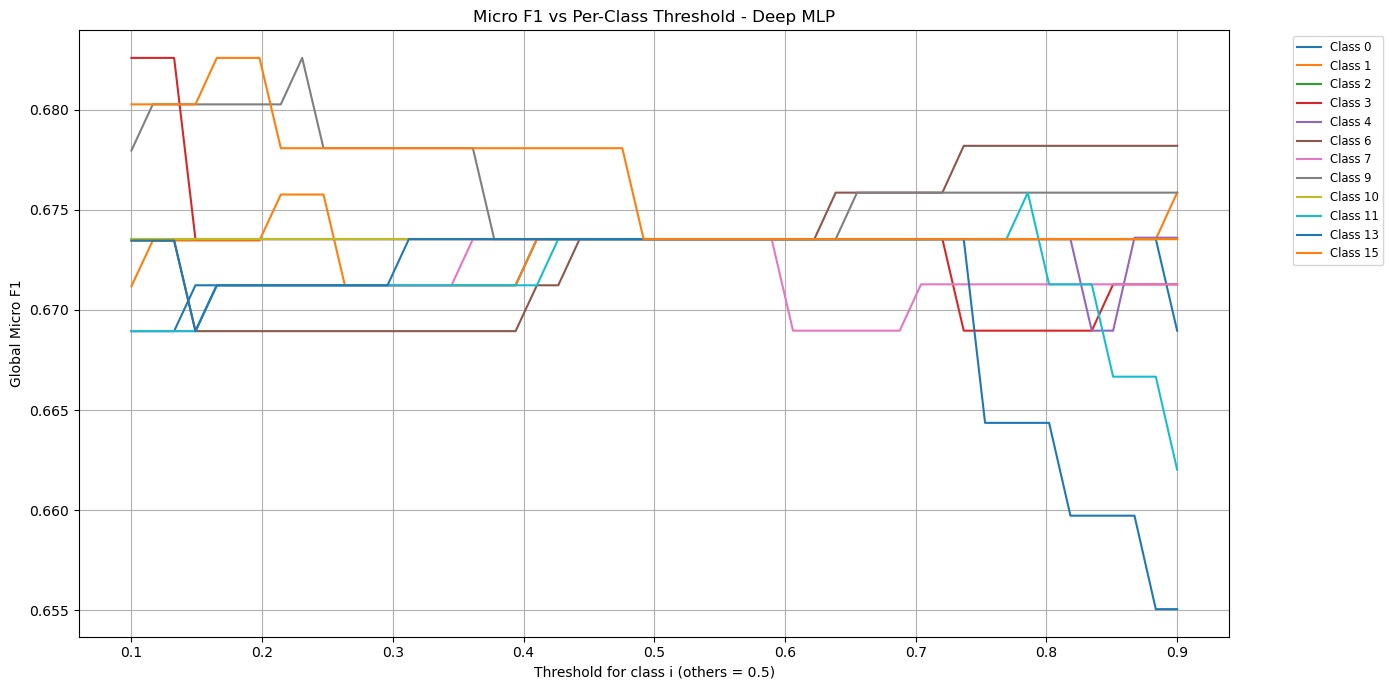

In [14]:
# === Plot 4: Micro F1 vs Per-Class Threshold ===

plt.figure(figsize=(14, 7))
for i in range(num_classes):
    if np.sum(y_test[:, i]) == 0:
        continue  # skip dead class
    micro_f1s = []
    for t in thresholds:
        test_thresholds = np.full(num_classes, 0.5)
        test_thresholds[i] = t
        y_pred_temp = (y_pred_prob >= test_thresholds).astype(int)
        score = f1_score(y_test, y_pred_temp, average='micro', zero_division=0)
        micro_f1s.append(score)
    plt.plot(thresholds, micro_f1s, label=f'Class {i}')

plt.xlabel("Threshold for class i (others = 0.5)")
plt.ylabel("Global Micro F1")
plt.title("Micro F1 vs Per-Class Threshold - Deep MLP")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
